# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


In [5]:
train_df = pd.read_csv('./data/train_processed.csv')
test_df = pd.read_csv('./data/test_processed.csv')
# I don't know why this keeps happening
train_df = train_df.drop('Unnamed: 0', 1)
test_df = test_df.drop('Unnamed: 0', 1)
train_df.head()
test_df.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,season_1.0,season_2.0,season_3.0,...,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,weather_1.0,weather_2.0,weather_3.0,temp_norm,atemp_norm,humidity_norm,windspeed_norm
0,0.0,1.0,2.0,6.0,56.2083,0.194037,3830.0,1,0,0,...,1,0,0,1,0,0,-1.341801,-1.363792,-0.500703,0.040945
1,0.0,1.0,1.0,3.0,65.2917,0.350133,2114.0,1,0,0,...,1,0,0,0,1,0,-1.431146,-1.665877,0.132958,2.036025
2,0.0,1.0,36.0,37.0,56.8333,0.149883,915.0,0,1,0,...,1,0,0,0,1,0,1.695943,1.757749,-0.457103,-0.523392
3,0.0,1.0,8.0,12.0,49.0833,0.268033,4322.0,1,0,0,...,0,0,0,1,0,0,-0.805728,-0.759623,-0.997746,0.986696
4,0.0,0.0,28.0,29.0,69.7083,0.215171,6591.0,0,1,0,...,0,0,0,1,0,0,0.981180,0.952190,0.441062,0.311061


## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.


/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


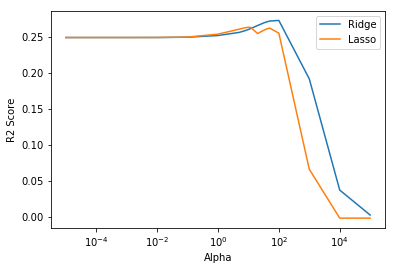

Best Lasso: 10
Best Ridge: 100


Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [6]:
# Use Ridge and Lasso regression to create models on the training set

# Remove the numeric columns that have been normalized separately, as well as the redundant categorical columns
remove_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'count', 'season_3.0', 'month_12.0', 'day_of_week_6.0', 'weather_3.0']

Xtrain = train_df[train_df.columns.difference(remove_cols)]
Xtest  = test_df[test_df.columns.difference(remove_cols)]
predictors = list(Xtrain)
#  Create response 
ytrain = train_df['count']
ytest  = test_df['count']

alphas = [.00001, .0001, .001, .01, .1, 1, 5, 8, 10, 12, 20, 30, 35, 40, 45, 50, 100, 1000, 10000, 100000]
r2s = {'ridge':[], 'lasso':[]}

for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    lasso.fit(Xtrain, ytrain)
    #print("ALPHA "+str(alpha))
    #print(clf.coef_)
    #print(clf.intercept_)
    lasso_preds = lasso.predict(Xtest)
    r2s['lasso'].append(r2_score(ytest, lasso_preds))
    
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(Xtrain, ytrain)
    ridge_preds = ridge.predict(Xtest)
    r2s['ridge'].append(r2_score(ytest, ridge_preds))
    

plt.semilogx(alphas, r2s['ridge'], label='Ridge')
plt.semilogx(alphas, r2s['lasso'], label='Lasso')
plt.ylabel("R2 Score")
plt.xlabel("Alpha")
plt.legend()
plt.show()

winningRidge = np.argmax(r2s['ridge'])
winningLasso = np.argmax(r2s['lasso'])
print("Best Lasso: "+str(alphas[winningLasso]))
print("Best Ridge: "+str(alphas[winningRidge]))

lasso = Lasso(alpha=alphas[winningLasso], fit_intercept=True)
lasso.fit(Xtrain, ytrain)

ridge = Ridge(alpha=alphas[winningRidge], fit_intercept=True)
ridge.fit(Xtrain, ytrain)

    

In [7]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(Xtrain, ytrain)

predictors = np.array(predictors)
coefficients = np.transpose([predictors, ridge.coef_, lasso.coef_, linreg.coef_])
coefficients_df = pd.DataFrame(coefficients, columns=['predictors', 'Ridge', 'Lasso', 'Normal'])
coefficients_df.head(len(coefficients_df))


,predictors,Ridge,Lasso,Normal
0,atemp_norm,471.65686796460324,452.32036774443935,312.43407188889796
1,day_of_week_0.0,-84.42496035271255,-306.2418651503781,-465.1450099570902
2,day_of_week_1.0,-89.06248939039168,-201.48785387674346,-256.6500506662598
3,day_of_week_2.0,-31.189729499901865,-144.6498385720568,-328.1845068957066
4,day_of_week_3.0,39.961127678447966,0.0,37.61277259517965
5,day_of_week_4.0,25.985191169271868,-0.0,-71.64254439857939
6,day_of_week_5.0,57.02446103414826,9.51114916914812,-21.831674879257434
7,holiday,-43.34246184082053,-179.77933843895644,-616.6027102985504
8,humidity_norm,-354.4763637051971,-567.6253916153483,-548.4929490582165
9,month_1.0,-157.83011306540536,-65.66318839582553,118.83581871663228


We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 1.1102230246251565e-16, 0.0]


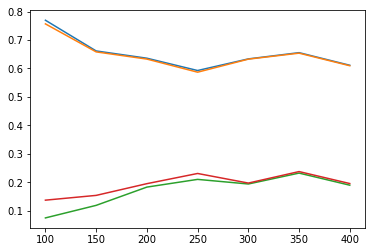

In [8]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def get_samples(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    return (x_subset, y_subset)

sample_sizes = [100, 150, 200, 250, 300, 350, 400]
r2s = {'ridge':{}, 'lasso':{}}

for sample_size in sample_sizes:
    X_sample, y_sample = get_samples(Xtrain.values, ytrain.values, sample_size)

    r2s['ridge'][sample_size] = {'test': {'samples': [], 'std':None, 'mean':None}, 'train': {'samples': [], 'std':None, 'mean':None}}
    r2s['lasso'][sample_size] = {'test': {'samples': [], 'std':None, 'mean':None}, 'train': {'samples': [], 'std':None, 'mean':None}}
    
    for i in range(10):
        ridge = Ridge()
        ridge.fit(X_sample, y_sample)
        ridge_train_predictions = ridge.predict(X_sample)
        r2s['ridge'][sample_size]['train']['samples'].append(r2_score(y_sample, ridge_train_predictions))
        
        ridge_test_predictions = ridge.predict(Xtest)
        r2s['ridge'][sample_size]['test']['samples'].append(r2_score(ytest, ridge_test_predictions))
        
        lasso = Lasso()
        lasso.fit(X_sample, y_sample)
        lasso_train_predictions = lasso.predict(X_sample)
        r2s['lasso'][sample_size]['train']['samples'].append(r2_score(y_sample, lasso_train_predictions))
        
        lasso_test_predictions = lasso.predict(Xtest)
        r2s['lasso'][sample_size]['test']['samples'].append(r2_score(ytest, lasso_test_predictions))
        
        
    r2s['ridge'][sample_size]['train']['mean'] = np.mean(r2s['ridge'][sample_size]['train']['samples'])
    r2s['ridge'][sample_size]['train']['std'] = np.std(r2s['ridge'][sample_size]['train']['samples'])
    
    r2s['lasso'][sample_size]['train']['mean'] = np.mean(r2s['lasso'][sample_size]['train']['samples'])
    r2s['lasso'][sample_size]['train']['std'] = np.std(r2s['lasso'][sample_size]['train']['samples'])
    
    r2s['ridge'][sample_size]['test']['mean'] = np.mean(r2s['ridge'][sample_size]['test']['samples'])
    r2s['ridge'][sample_size]['test']['std'] = np.std(r2s['ridge'][sample_size]['test']['samples'])
    
    r2s['lasso'][sample_size]['test']['mean'] = np.mean(r2s['lasso'][sample_size]['test']['samples'])
    r2s['lasso'][sample_size]['test']['std'] = np.std(r2s['lasso'][sample_size]['test']['samples'])


print([r2s['lasso'][s]['train']['std'] for s in sample_sizes])
plt.figure()
plt.errorbar(sample_sizes, [r2s['lasso'][s]['train']['mean'] for s in sample_sizes], yerr=[r2s['lasso'][s]['train']['std'] for s in sample_sizes])
plt.errorbar(sample_sizes, [r2s['ridge'][s]['train']['mean'] for s in sample_sizes], yerr=[r2s['ridge'][s]['train']['std'] for s in sample_sizes])


plt.errorbar(sample_sizes, [r2s['lasso'][s]['test']['mean'] for s in sample_sizes], yerr=[r2s['lasso'][s]['test']['std'] for s in sample_sizes])
plt.errorbar(sample_sizes, [r2s['ridge'][s]['test']['mean'] for s in sample_sizes], yerr=[r2s['ridge'][s]['test']['std'] for s in sample_sizes])

plt.show()


- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

In [9]:
# your code here

#### Q: How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrinkage penalty) in Part (b) from HW 3? <br><br> A:  Doing a quick visual comparison, refer to the "coefficients_df.head" output above, we observe the estimated coefficients for both Ridge and Lasso regression appear to be lower, on average, than plain linear regression with some (6) of the Lasso coefficients are zeroed out.  We verify this observation more rigorously by computing the mean and standard deviation of the absolute values of the estimated coefficients (see above).  Both the mean and standard deviation is lowest for Ridge, followed by Lasso, following by plain linear regression.  This is expected since coefficient shrinkage is the main goal of Ridge and Lasso regression, and in the case of Lasso, variable reduction (some coefficients = 0). <br><br><br>Q: Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference. <br><br> A: Yes, both methods perform coefficient shrinkage, however, Lasso also zeroes out coefficients thereby producing a sparser solution.  The reason for this difference is that Lasso speciifies a constraint defined on the sum of the absolute values of the estimated coefficients (L1 Norm) vs the sum of the squares of the estimated coefficients (L2 Norm). The nature of using the L1 Norm constraint has the effect of zeroing out coefficients while the L2 Norm constraint merely has the effect of reducing the estimated coefficients.  <br><br><br>Q: List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3? <br><br> A:  For Ridge regression, no predictors were set very close to zero (< 1e-10).  For Lasso regression, six (6) coefficients are assigned to 0: day_of_week_3.0, day_of_week_4.0, month_2.0, month_5.0, month_11.0, and workingday.   In Part (c) of HW3, working days, holidays, and days of week were identified as having strong correlations.  Lasso zeroed out working days.   <br><br><br>  Q: Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors temp and atemp? If so, explain the reason for the difference. <br><br> A: The predictors temp and atemp are highly correlated (0.98) predictors.  Ridge assigns both of these predictors approximately the same value (472 and 469), while Lasso assigns them different values (452 and 680).   ???Would expect Lasso to assign one of these predictors to zero¿¿¿

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [10]:
from sklearn.linear_model import LinearRegression

def get_summary_df(X, y):
    ols = sm.OLS(y, X).fit()
    
    summary_data = ols.summary().tables[1].data
    header = summary_data.pop(0)
    header[0] = 'predictor'

    # We get the data as strings -- convert here. 
    for i in range(len(summary_data)):
        summary_data[i][1] = float(summary_data[i][1])
        summary_data[i][2] = float(summary_data[i][2])
        summary_data[i][3] = float(summary_data[i][3])
        summary_data[i][4] = float(summary_data[i][4])
        summary_data[i][5] = float(summary_data[i][5])
        summary_data[i][6] = float(summary_data[i][6])
        
    summary_df = pd.DataFrame(summary_data, columns=header)
    return summary_df

# Predictors
numeric_cols = ['temp_norm', 'atemp_norm', 'humidity_norm', 'windspeed_norm']
Xtrain_poly = Xtrain.copy()
Xtest_poly = Xtest.copy()

for numeric_col in numeric_cols:
    Xtrain_poly[numeric_col+'_2'] = Xtrain[numeric_col]**2
    Xtrain_poly[numeric_col+'_3'] = Xtrain[numeric_col]**3
    Xtrain_poly[numeric_col+'_4'] = Xtrain[numeric_col]**4
    
    Xtest_poly[numeric_col+'_2'] = Xtest[numeric_col]**2
    Xtest_poly[numeric_col+'_3'] = Xtest[numeric_col]**3
    Xtest_poly[numeric_col+'_4'] = Xtest[numeric_col]**4
Xtrain_poly.head()


linreg = LinearRegression().fit(Xtrain_poly, ytrain)
trainPreds = linreg.predict(Xtrain_poly)
print("Train R2:")
print(r2_score(ytrain, trainPreds))

testPreds = linreg.predict(Xtest_poly)
print("Test R2:")
print(r2_score(ytest, testPreds))

Xtest_intercept = sm.add_constant(Xtest_poly)
summary_df = get_summary_df(Xtest_intercept, ytest)
summary_df.sort_values('P>|t|', inplace=True)
summary_df.head(30)


Train R2:
0.669656240221
Test R2:
0.277238435086


,predictor,coef,std err,t,P>|t|,[0.025,0.975]
0,const,3651.0945,1061.216,3.440,0.001,1564.133,5738.056
29,temp_norm_2,-2759.4370,1002.647,-2.752,0.006,-4731.218,-787.656
25,weather_1.0,1984.3455,736.827,2.693,0.007,535.319,3433.372
34,atemp_norm_4,-376.7993,147.915,-2.547,0.011,-667.686,-85.913
26,weather_2.0,1774.8474,694.078,2.557,0.011,409.890,3139.805
32,atemp_norm_2,2198.9751,903.790,2.433,0.015,421.604,3976.346
7,day_of_week_5.0,521.6191,230.018,2.268,0.024,69.271,973.967
6,day_of_week_4.0,475.1143,223.309,2.128,0.034,35.960,914.269
9,humidity_norm,-454.5818,215.594,-2.109,0.036,-878.564,-30.600
15,month_4.0,-1376.1298,715.532,-1.923,0.055,-2783.277,31.017


In [11]:
Xtrain_interaction = Xtrain.copy()
Xtest_interaction = Xtest.copy()

months = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']
weathers = ['1.0', '2.0']

for month in months:
    Xtrain_interaction['temp_month_'+month] = Xtrain['month_'+month]* Xtrain['temp_norm']
    Xtest_interaction['temp_month_'+month] = Xtest['month_'+month]* Xtest['temp_norm']

for weather in weathers:
    Xtrain_interaction['working_weather_'+month] = Xtrain['weather_'+weather] * Xtrain['workingday']
    Xtest_interaction['working_weather_'+month] = Xtest['weather_'+weather] * Xtest['workingday']
    
Xtrain_interaction.head()

linreg = LinearRegression().fit(Xtrain_interaction, ytrain)
trainPreds = linreg.predict(Xtrain_interaction)
print("Train R2:")
print(r2_score(ytrain, trainPreds))

testPreds = linreg.predict(Xtest_interaction)
print("Test R2:")
print(r2_score(ytest, testPreds))

Xtest_intercept = sm.add_constant(Xtest_interaction)
summary_df = get_summary_df(Xtest_intercept, ytest)
summary_df.sort_values('P>|t|', inplace=True)
summary_df.head(30)

Train R2:
0.668934037226
Test R2:
0.264607295698


,predictor,coef,std err,t,P>|t|,[0.025,0.975]
0,const,5323.2503,1189.500,4.475,0.000,2984.009,7662.491
35,temp_month_7.0,-5212.4875,1361.987,-3.827,0.000,-7890.938,-2534.037
34,temp_month_6.0,-6283.1998,1163.960,-5.398,0.000,-8572.215,-3994.185
26,weather_2.0,2840.8660,638.731,4.448,0.000,1584.752,4096.980
25,weather_1.0,2705.0879,593.435,4.558,0.000,1538.054,3872.122
24,temp_norm,5816.2396,1405.182,4.139,0.000,3052.843,8579.636
39,temp_month_11.0,-4170.4130,1183.890,-3.523,0.000,-6498.623,-1842.203
12,month_11.0,-4274.6630,1159.220,-3.688,0.000,-6554.356,-1994.970
15,month_4.0,-3592.7561,1113.269,-3.227,0.001,-5782.084,-1403.428
11,month_10.0,-2669.7716,915.400,-2.917,0.004,-4469.974,-869.569


In [12]:
your answers here

SyntaxError: invalid syntax (<ipython-input-12-7a72612d9ba8>, line 1)

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [13]:
all_predictors = list(Xtrain_poly)
non_poly_predictors = set(list(Xtrain)) - set(numeric_cols)

Xtrain_big = Xtrain_poly.copy()

Xtest_big = Xtest_poly.copy()
for predictor1 in all_predictors:
    for predictor2 in non_poly_predictors:
        Xtrain_big[predictor1+'X'+predictor2] = Xtrain_poly[predictor1]* Xtrain_poly[predictor2]
        Xtest_big[predictor1+'X'+predictor2] = Xtest_poly[predictor1]* Xtest_poly[predictor2]


numeric_strings = ['humidity', 'temp', 'windspeed']
# Get a list of all the columns with either temp, humidity, or windspeed

numeric_cols = [name for name in list(Xtrain_big) if any(num in name for num in numeric_strings)]

#Normalize the data
for numeric_col in numeric_cols:
    Xtest_big[numeric_col] = Xtest_big[numeric_col].transform(lambda x, m = Xtrain_big[numeric_col].mean(), 
                                                                          s = Xtrain_big[numeric_col].std()
                                                                          : (x - m)/s )
    # Rescale train data using mean and std computed from train
Xtrain_big[numeric_cols] = Xtrain_big[numeric_cols].transform(lambda x: (x - x.mean()) / x.std())


Xtrain_big.describe()


,atemp_norm,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,holiday,humidity_norm,month_1.0,...,windspeed_norm_4Xday_of_week_2.0,windspeed_norm_4Xday_of_week_1.0,windspeed_norm_4Xmonth_3.0,windspeed_norm_4Xday_of_week_4.0,windspeed_norm_4Xday_of_week_0.0,windspeed_norm_4Xday_of_week_3.0,windspeed_norm_4Xday_of_week_5.0,windspeed_norm_4Xmonth_2.0,windspeed_norm_4Xweather_1.0,windspeed_norm_4Xworkingday
count,3.310000e+02,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,331.000000,...,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02
mean,-5.433720e-17,0.160121,0.175227,0.135952,0.123867,0.123867,0.145015,0.033233,2.012489e-17,0.078550,...,5.970384e-17,2.549153e-17,4.645495e-17,-1.133702e-16,1.304764e-16,-6.230330e-17,1.931151e-16,3.354148e-17,-8.989117e-17,6.641213e-17
std,1.000000e+00,0.367273,0.380736,0.343256,0.329929,0.329929,0.352649,0.179515,1.000000e+00,0.269442,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.572131e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.648736e+00,0.000000,...,-1.556308e-01,-1.341264e-01,-1.111391e-01,-1.352397e-01,-1.285487e-01,-1.707624e-01,-1.210952e-01,-1.113881e-01,-2.341945e-01,-2.759446e-01
25%,-8.603176e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.452412e-01,0.000000,...,-1.556308e-01,-1.341264e-01,-1.111391e-01,-1.352397e-01,-1.285487e-01,-1.707624e-01,-1.210952e-01,-1.113881e-01,-2.341945e-01,-2.759446e-01
50%,1.466312e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.562743e-03,0.000000,...,-1.556308e-01,-1.341264e-01,-1.111391e-01,-1.352397e-01,-1.285487e-01,-1.707624e-01,-1.210952e-01,-1.113881e-01,-2.334611e-01,-2.741981e-01
75%,7.508005e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.055719e-01,0.000000,...,-1.556308e-01,-1.341264e-01,-1.111391e-01,-1.352397e-01,-1.285487e-01,-1.707624e-01,-1.210952e-01,-1.113881e-01,-1.772616e-01,-1.735898e-01
max,1.959139e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.362380e+00,1.000000,...,1.212031e+01,1.518684e+01,1.434265e+01,1.563538e+01,1.626381e+01,1.114297e+01,1.589538e+01,1.123906e+01,9.744872e+00,9.827090e+00


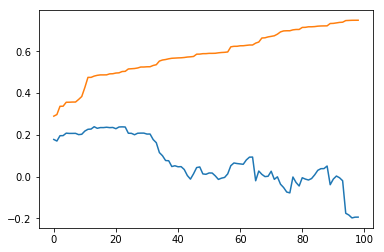

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(Xtrain_big)
#plt.plot(pca.explained_variance_[0:5])

PCA_vectors = pca.components_

r2s = {'test':[], 'train':[]}
for i in range(1,100):
    PCA_vector_subset = pd.DataFrame(PCA_vectors[0:i].transpose(), columns=['PCA '+str(j) for j in range(i)])

    # Use the PCA vectors to create reduced predictor columns

    reduced_train = np.dot(Xtrain_big.values, PCA_vector_subset.values)
    linreg = LinearRegression().fit(reduced_train, ytrain)
    
    train_preds = linreg.predict(reduced_train)
    r2s['train'].append(r2_score(ytrain, train_preds))
    
    reduced_test = np.dot(Xtest_big.values, PCA_vector_subset.values)
    test_preds = linreg.predict(reduced_test)
    r2s['test'].append(r2_score(ytest, test_preds))
    
plt.plot(r2s['test'])
plt.plot(r2s['train'])
plt.show()



In [15]:
# two datapoints, four attributes
df1 = pd.DataFrame([[2,4,6,8],[1,3,5,7],[1,3,5,7]])
print(df1.shape)
# Single vector
df2 = pd.DataFrame([[.5,1],[.5,1],[.5,1],[.5,1]])
print(df2.shape)

multiplied = df1.dot(df2)
multiplied.head()

(3, 4)
(4, 2)


,0,1
0,10.0,20.0
1,8.0,16.0
2,8.0,16.0


your answers here

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [16]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_




Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [17]:
# your code here

your answers here

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

In [158]:
# Fit a LR model and then remove 5% of the samples with the highest absolute residual error 
# and then refit a model without those samples.
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
#  Fit the LR model
lr.fit(Xtrain, ytrain)
# Predict on train
ytrain_pred = lr.predict(Xtrain)
# Predict on test
ytest_pred = lr.predict(Xtest)
# Get R2 test score
r2_score_test = r2_score(ytest, ytest_pred)
print("\nR2 LR Test Score with full train")
print (r2_score_test)
#  Get the residuals
abs_residuals = abs(ytrain_pred - ytrain)
# Sort of residual absolute values
abs_res = abs_residuals.sort_values(axis=0, ascending= False)
# Get indexes of Xtrain that DON'T include the 5% (20) worst residuals 
inds = abs_res.index[int(len(abs_res)*0.05):len(abs_res)]
#  Fit the LR model on the train subset with worst residual indexes removed
lr.fit(Xtrain.loc[inds], ytrain.loc[inds])
# Predict on test
ytest_pred = lr.predict(Xtest)
# Get R2 test score
r2_score_test = r2_score(ytest, ytest_pred)
print("\nR2 LR Test Score with partial train after removing 5% (20) of the worst residuals")
print (r2_score_test)





R2 LR Test Score with full train
0.249342111465

R2 LR Test Score with partial train after removing 5% (20) of the worst residuals
0.250203096354


331

#### your answers here